# Evaluating space-time compression with probabilistic forecast skill

In [1]:
using NetCDF, BitInformation, ZfpCompression
using PyPlot, FileIO, JLD2
using StatsBase, Statistics
using ProgressMeter
ticker = PyPlot.matplotlib.ticker

# CRPS
include("../src/crps.jl")

path = "/network/aopp/chaos/pred/kloewer/esowc/"
member1files = filter(x->endswith(x,".nc"),readdir(joinpath(path,"member1")))
steps = [parse(Int,split(split(file,"step")[2],".")[1]) for file in member1files]
sort!(steps)

# parameter
Nens = 25
Nbits = 32
Nlon = 1800
Nlat = 901
Nvert = 91
Nsteps = length(steps);

## 2. Load data for an example location (London)

In [2]:
# load one file for lon,lat indices
ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step0.ll.nc"))
lon = ncfile.vars["lon"][:]
lat = ncfile.vars["lat"][:];

In [3]:
# find indices for London
place0 = (0.0,51.5)
x0,y0 = findmin(abs.(lon .- place0[1]))[2],findmin(abs.(lat .- place0[2]))[2];

In [ ]:
# EITHER EXECUTE THIS OR LOAD PREVIOUS CALCULATION IN NEXT CELL
t = fill(0f0,Nens,Nsteps)           # original time series for London
t4d = fill(0f0,Nens,4,4,4,Nsteps)   # 4x4x4x4 block around London

for it in 1:Nsteps
    print("$it,")
    for ie in 1:Nens
        s = steps[it]
        file = joinpath(path,"member$ie","ensemble.t.member$ie.step$s.ll.nc")
        t[ie,it] = NetCDF.ncread(file,"t",start=[x0,y0,Nvert,1],count=[1,1,1,1])[1]
        t4d[ie,:,:,:,it] = NetCDF.ncread(file,"t",start=[x0,y0-2,Nvert-3,1],count=[4,4,4,1])[:,:,:]
    end
end

In [4]:
# LOAD PRECOMPUTED RESULT OF PREVIOUS CELL
filepath = joinpath(path,"analysis","london.jld2")
# save(filepath,"t",t,"t4d",t4d)
t,t4d = load(filepath,"t","t4d");

## 3. Compress London forecast with Zstd/Zfp

In [5]:
# Zstd, just round here as we only analyse the error
x = hcat(round(t[:,1:34],10),round(t[:,35:102],9),round(t[:,103:end],8));

# Zfp compress in chunks of at least 4x4x4x4 for largest compressability
z1 = zero(x)
z2 = zero(x)
z3 = zero(x)

for ie in 1:Nens
    z1[ie,:] = zfp_decompress(zfp_compress(t4d[ie,:,:,:,:],precision=14))[1,3,4,:]
    z2[ie,:] = zfp_decompress(zfp_compress(t4d[ie,:,:,:,:],precision=13))[1,3,4,:]
    z3[ie,:] = zfp_decompress(zfp_compress(t4d[ie,:,:,:,:],precision=12))[1,3,4,:]
end

## 4. CRPS wrt temperature analysis (London only)

In [6]:
# LOAD TEMPERATURE ANALYSIS
an_files = filter(x->endswith(x,".nc"),readdir(joinpath(path,"an")))
sort!(an_files)
an_steps = collect(0:6:360)    # comes in 6h intervals
an_t = fill(0f0,length(an_steps))

@showprogress for (i,filename) in enumerate(an_files)
    file = joinpath(path,"an",filename)
    an_t[i] = NetCDF.ncread(file,"t",start=[x0,y0,Nvert,1],count=[1,1,1,1])[1]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


In [7]:
# calculate CRPS of compressed time series with respect to temperature analysis
crps_t = zero(an_t)
crps_z1 = zero(an_t)
crps_z2 = zero(an_t)
crps_z3 = zero(an_t)

for i in 1:length(an_steps)
    si = an_steps[i] .== steps
    crps_t[i] = CRPS(t[:,si][:],an_t[i])
    crps_z1[i] = CRPS(z1[:,si][:],an_t[i])
    crps_z2[i] = CRPS(z2[:,si][:],an_t[i])
    crps_z3[i] = CRPS(z2[:,si][:],an_t[i])
end    

## 3. GLOBAL CRPS wrt temperature analysis

Repeat the previous calculation for global surface temperature

CRPS is
$$
CRPS = \int_{-\infty}^\infty (P_{fc}(x) - P_y(x))^2 dx
$$
with $P_y$ the cumulative distribution function (cdf) of the observations (just the Heaviside function $H(x-y)$), and $P_{fc}$ the cdf of the forecast.

In [ ]:
# EITHER EXECUTE THIS CELL OR LOAD PREVIOUSLY COMPUTED ARRAYS
chunksize = 4
Nchunks = Nsteps÷chunksize                             # compress in chunks of 4 time steps
crps_surface = fill(0f0,Nlon,Nlat,length(an_steps))    # CRPS for original data
crps_surfacz1 = fill(0f0,Nlon,Nlat,length(an_steps))   # CRPS for ZFP compression: 99.5% 
crps_surfacz2 = fill(0f0,Nlon,Nlat,length(an_steps))   # CRPS for ZFP compression: 98%
crps_surfacz3 = fill(0f0,Nlon,Nlat,length(an_steps))   # CRPS for ZFP compression: 95%

compress_fac_z1 = fill(0f0,Nens,length(an_steps))      # compression factors
compress_fac_z2 = fill(0f0,Nens,length(an_steps))
compress_fac_z3 = fill(0f0,Nens,length(an_steps))

cf_counter = 0

for ic in 1:Nchunks
    print("$ic")
    
    # hours of current chunk
    hours = [steps[(ic-1)*chunksize+i] for i in 1:chunksize]
    if any([h in an_steps for h in hours])
        
        cf_counter += 1
    
        temp = fill(0f0,Nlon,Nlat,4,chunksize,Nens)
        for iens in 1:Nens
            for i in 1:chunksize
                s = steps[(ic-1)*chunksize+i]
                ncfile = NetCDF.open(joinpath(path,"member$iens","ensemble.t.member$iens.step$s.ll.nc"))
                temp[:,:,:,i,iens] = ncfile.vars["t"][:,:,end-3:end]
            end
        end
        print("L")
        
        # ZFP compression        
        tempz1 = copy(temp)
        tempz2 = copy(temp)
        tempz3 = copy(temp)
        
        for iens in 1:Nens
            # 99.5% information preserved, +-0.1˚C
            C = zfp_compress(temp[:,:,:,:,iens],precision=14,nthreads=4)
            compress_fac_z1[iens,cf_counter] = 2*sizeof(temp)/Nens/sizeof(C)
            tempz1[:,:,:,:,iens] = zfp_decompress(C)
            
            # 98% of information preserved, +-0.2˚C
            C = zfp_compress(temp[:,:,:,:,iens],precision=13,nthreads=4)
            compress_fac_z2[iens,cf_counter] = 2*sizeof(temp)/Nens/sizeof(C)
            tempz2[:,:,:,:,iens] = zfp_decompress(C)
            
            # 95% of information preserved, +-0.4˚C
            C = zfp_compress(temp[:,:,:,:,iens],precision=12,nthreads=4)
            compress_fac_z3[iens,cf_counter] = 2*sizeof(temp)/Nens/sizeof(C)
            tempz3[:,:,:,:,iens] = zfp_decompress(C)
        end
        print("X")
        
        # CALCULATE CRPS NOW
        for (ih,h) in enumerate(hours)
            if h in an_steps
                # LOAD TEMPERATURE ANALYSIS DATA
                hidx = h÷6+1
                filename = an_files[hidx]
                ncfile = NetCDF.open(joinpath(path,"an",filename))
                an_temp = ncfile.vars["t"][:,:,end]
                print("Λ")

                for ilon in 1:Nlon
                    for ilat in 1:Nlat
                        temp_xyzt = temp[ilon,ilat,end,ih,:]
                        crps_surface[ilon,ilat,hidx] = CRPS(temp_xyzt,an_temp[ilon,ilat])
                        crps_surfacz1[ilon,ilat,hidx] = CRPS(tempz1[ilon,ilat,end,ih,:],an_temp[ilon,ilat])
                        crps_surfacz2[ilon,ilat,hidx] = CRPS(tempz2[ilon,ilat,end,ih,:],an_temp[ilon,ilat])
                        crps_surfacz3[ilon,ilat,hidx] = CRPS(tempz3[ilon,ilat,end,ih,:],an_temp[ilon,ilat])
                    end
                end
                print("C,")
            end
        end
    end
end

In [8]:
# LOAD INSTEAD OF RECALCULATION GLOBAL CRPS EVERYTIME
filepath = joinpath(path,"analysis","crps.jld2")
# @save filepath crps_surface crps_surfacz1 crps_surfacz2 crps_surfacz3
@load filepath crps_surface crps_surfacz1 crps_surfacz2 crps_surfacz3

4-element Vector{Symbol}:
 :crps_surface
 :crps_surfacz1
 :crps_surfacz2
 :crps_surfacz3

In [14]:
# GLOBAL AVERAGE / INTERDECILE RANGE
crps_m = zeros(length(an_t)-1)      # mean
crpsz1_m = zeros(length(an_t)-1)
crpsz2_m = zeros(length(an_t)-1)
crpsz3_m = zeros(length(an_t)-1)

# cosine weights
w = weights(cosd.(repeat(lat,1,1800)'))

for i in 1:length(an_t)-1
    crps_m[i] = mean(crps_surface[:,:,i],w)
    crpsz1_m[i] = mean(crps_surfacz1[:,:,i],w)
    crpsz2_m[i] = mean(crps_surfacz2[:,:,i],w)
    crpsz3_m[i] = mean(crps_surfacz3[:,:,i],w)
end

## 3. PLOTTING

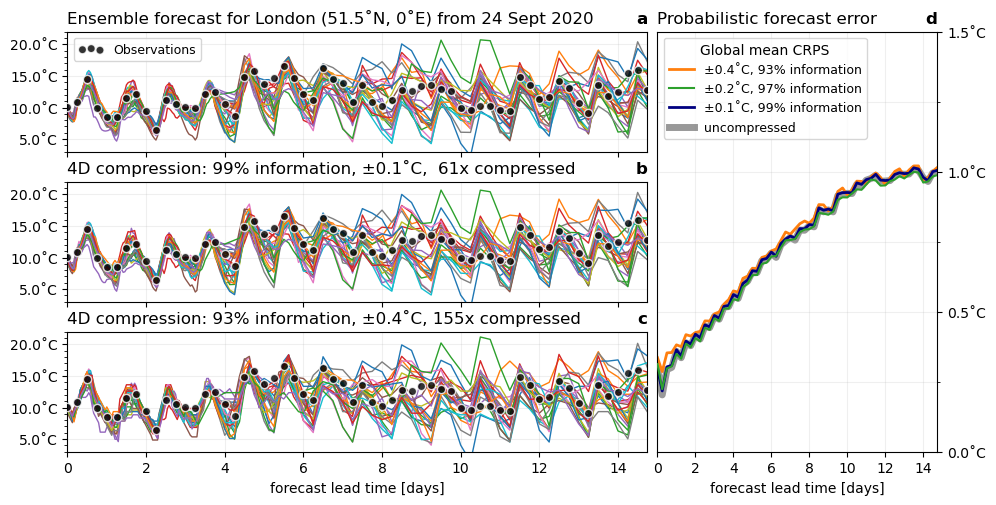

In [16]:
days = steps/24         # steps [hours] to days
an_days = an_steps/24
k = 273.15    # Kelvin to Celsius

fig = figure(figsize=(10,5))

x0,x1 = 0.07,0.66
y0,y1,y2 = 0.1,0.4,0.7
xw0,xw1 = 0.58,0.28
yh0,yh1 = 0.24,0.84

ax1 = fig.add_axes([x0,y2,xw0,yh0])
ax2 = fig.add_axes([x0,y1,xw0,yh0])
ax3 = fig.add_axes([x0,y0,xw0,yh0])
axr = fig.add_axes([x1,y0,xw1,yh1])

# plot ensemble
ax1.plot(days,t' .- k,lw=1)
ax2.plot(days,z1' .- k,lw=1)
ax3.plot(days,z3' .- k,lw=1)

# plot observations
ax1.scatter(an_steps/24,an_t .- k,35,"k",edgecolor="w",alpha=0.8,label="Observations",zorder=10)
ax2.scatter(an_steps/24,an_t .- k,35,"k",edgecolor="w",alpha=0.8,zorder=10)
ax3.scatter(an_steps/24,an_t .- k,35,"k",edgecolor="w",alpha=0.8,zorder=10)
ax1.legend(loc=2,fontsize=9,scatterpoints=3)

# CRPS
axr.plot(an_days[1:end-1],crpsz3_m,"C1",lw=2,label="±0.4˚C, 93% information")
axr.plot(an_days[1:end-1],crpsz2_m,"C2",lw=1.5,zorder=3,label="±0.2˚C, 97% information")
axr.plot(an_days[1:end-1],crpsz1_m,"navy",lw=2.,zorder=2,label="±0.1˚C, 99% information")
axr.plot(an_days[1:end-1],crps_m,"k",lw=5,alpha=.4,zorder=1,label="uncompressed")

axr.legend(loc=2,fontsize=9,title="Global mean CRPS")

# axis settings
for ax in [ax1,ax2,ax3]
    ax.set_yticks(3:22,minor=true)
    ax.set_ylim(3,22)
    ax.set_xlim(0,14.75)
end

axr.set_yticks(0:0.5:1.5)
axr.set_yticks(0:0.25:2,minor=true)
axr.yaxis.tick_right()
axr.set_ylim(0,1.5)
axr.set_xlim(0,14.75)
axr.set_xticks(0:2:14)

for ax in [ax1,ax2]
    ax.set_xticklabels([])
end

ax3.set_xlabel("forecast lead time [days]")
axr.set_xlabel("forecast lead time [days]")
ax1.set_title("Ensemble forecast for London (51.5˚N, 0˚E) from 24 Sept 2020",loc="left")
ax2.set_title("4D compression: 99% information, ±0.1˚C,  61x compressed",loc="left")
ax3.set_title("4D compression: 93% information, ±0.4˚C, 155x compressed",loc="left")
axr.set_title("Probabilistic forecast error",loc="left")

for (iax,ax) in enumerate([ax1,ax2,ax3,axr])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f˚C"))
    ax.set_title(string(Char(96+iax)),loc="right",fontweight="bold")
end

for ax in [ax1,ax2,ax3]
    ax.grid(alpha=.2)
end
axr.grid(alpha=.2,which="both",axis="both")

# tight_layout()
savefig("ensemble_forecast.png",dpi=200)
savefig("ensemble_forecast.pdf")

# Output

In [25]:
using DataFrames, CSV

In [27]:
CRPSout = hcat(an_days[1:end-1],an_t[1:end-1] .- k,crps_m,crpsz1_m,crpsz2_m,crpsz3_m)
df = DataFrame(Float32.(CRPSout),:auto)
CSV.write("Fig6_obs_crps_data.csv",df,header=["time [days]",
                                                "Temp obs. [degC]",
                                                "CRPS (uncompressed)",
                                                "CRPS (99% information)",
                                                "CRPS (97% information)",
                                                "CRPS (93% information)"])

"Fig6_obs_crps_data.csv"

In [33]:
# uncompressed
Tout = hcat(days,t' .- k)
columns = vcat(["time [days]"],["Temp [degC] member $i" for i in 1:25])
df = DataFrame(Float32.(Tout),:auto)
CSV.write("Fig6_temp_ensemble_uncompressed.csv",df,header=columns)

"Fig6_temp_ensemble_uncompressed.csv"

In [34]:
# 99% information
Tout = hcat(days,z1' .- k)
df = DataFrame(Float32.(Tout),:auto)
CSV.write("Fig6_temp_ensemble_99inf.csv",df,header=columns)

"Fig6_temp_ensemble_99inf.csv"

In [35]:
# 93% information
Tout = hcat(days,z3' .- k)
df = DataFrame(Float32.(Tout),:auto)
CSV.write("Fig6_temp_ensemble_93inf.csv",df,header=columns)

"Fig6_temp_ensemble_93inf.csv"